In [ ]:
data_base_url = (
    "https://data.vespa-cloud.com/tests/performance/nearest-neighbor/gist-data/"
)

SCALE_DOWN = False
docs_url = (
    data_base_url + "docs.1k.json" if SCALE_DOWN else data_base_url + "docs.300k.json"
)
query_url = (
    data_base_url + "query_vectors.10.txt"
    if SCALE_DOWN
    else data_base_url + "query_vectors.100.txt"
)

In [ ]:
import os
import pathlib
import requests
import matplotlib.pyplot as plt
from vespa.io import VespaResponse

# download data files


def download_file(url: str, dest_folder: str):
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename


data_path = "ann_test/"
pathlib.Path(data_path).mkdir(parents=True, exist_ok=True)
docs_path = download_file(docs_url, data_path)
query_path = download_file(query_url, data_path)

In [8]:
from vespa.package import (
    ApplicationPackage,
    Schema,
    Document,
    Field,
    RankProfile,
    HNSW,
    DocumentSummary,
    Summary,
)
from vespa.configuration.query_profiles import query_profile, query_profile_type, field


# Define the document with fields
doc = Document(
    fields=[
        Field(
            name="id",
            type="int",
            indexing=["attribute", "summary"],
        ),
        Field(
            name="filter",
            type="array<int>",
            indexing=["attribute", "summary"],
            attribute=["fast-search"],
        ),
        Field(
            name="vec_m16",
            type="tensor<float>(x[960])",
            indexing=["attribute", "index", "summary"],
            ann=HNSW(
                distance_metric="euclidean",
                max_links_per_node=16,
                neighbors_to_explore_at_insert=500,
            ),
        ),
    ]
)

# Define the rank profile with HNSW tuning parameters
rank_profile = RankProfile(
    name="default",
    inputs=[
        ("query(q_vec)", "tensor<float>(x[960])"),
    ],
    first_phase="closeness(label,nns)",
    rank_properties=[
        ("approximate-threshold", 0.05),
        ("filter-first-threshold", 0.0),
        ("filter-first-exploration", 0.3),
        ("exploration-slack", 0.0),
    ],
)

# Define document summary
minimal_summary = DocumentSummary(name="minimal", summary_fields=[Summary(name="id")])

# Create the schema
schema = Schema(
    name="test",
    document=doc,
    rank_profiles=[rank_profile],
    document_summaries=[minimal_summary],
)


qp = query_profile(
    id="default",
    type="root",
)

qpt = query_profile_type(
    field(
        name="ranking.features.query(q_vec)",
        type="tensor<float>(x[960])",
    ),
    id="root",
    inherits="native",
)

# Create the application package
app_package = ApplicationPackage(
    name="test", schema=[schema], query_profile_config=[qp, qpt]
)

<query-profile-type id="root" inherits="native">
  <field name="ranking.features.query(q_vec)" type="tensor&lt;float&gt;(x[960])" />
</query-profile-type>

<query-profile id="default" type="root" />

In [9]:
app_package.to_files("ann_test")

In [10]:
from vespa.deployment import VespaDocker

vespa_docker = VespaDocker()

In [11]:
from vespa.application import Vespa

app: Vespa = vespa_docker.deploy(app_package)

Waiting for configuration server, 0/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for application to come up, 0/300 seconds.
Waiting for application to come up, 0/300 seconds.
Waiting for application to come up, 5/300 seconds.
Waiting for application to come up, 5/300 seconds.
Waiting for application to come up, 10/300 seconds.
Waiting for application to come up, 10/300 seconds.
Waiting for application to come up, 15/300 seconds.
Waiting for application to come up, 15/300 seconds.
Waiting for application to come up, 20/300 seconds.
Waiting for application to come up, 20/300 seconds.
Application is up!
Finished deployment.
Application is up!
Finished deployment.


In [13]:
# Load and feed documents
import json

# load json file (it is array of documents)

with open(docs_path, "r") as f:
    docs = json.load(f)

docs_formatted = [
    {
        "id": str(doc["fields"]["id"]),
        "fields": doc["fields"],
    }
    for doc in docs
]

In [57]:
print(len(docs_formatted))

300000


In [ ]:
def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print("Id " + id + " + failed : " + response.json)


app.feed_iterable(docs_formatted)

In [43]:
import vespa.querybuilder as qb


def vector_to_query(vec_str: str, filter_value: int) -> dict:
    return {
        # "select * from test where {targetHits:1000}nearestNeighbor(vec_m16, q_vec);"
        "yql": str(
            qb.select("*")
            .from_("test")
            .where(
                qb.nearestNeighbor(
                    "vec_m16",
                    "q_vec",
                    annotations={
                        "targetHits": 100,
                        "approximate": True,
                        "label": "nns",
                    },
                )
                & (qb.QueryField("filter") == filter_value),
            )
        ),
        "hits": 10,
        "presentation.summary": "minimal",
        "timeout": "20s",
        "ranking.features.query(q_vec)": vec_str.strip(),
    }

In [44]:
with open(query_path, "r") as f:
    query_vectors = f.readlines()

# Filter values
filter_percentage = [1, 10, 50, 90, 95, 99]

queries = []
for filter_value in filter_percentage:
    for vec in query_vectors:
        queries.append(vector_to_query(vec, filter_value))
print(len(queries))

600


In [45]:
q_str = "/search/?yql=select%20*%20from%20sources%20*%20where%20[%7B%22targetNumHits%22:100,%22hnsw.exploreAdditionalHits%22:0,%22approximate%22:true,%22label%22:%22nns%22%7D]nearestNeighbor(vec_m16,q_vec)%20and%20filter%3D10;&ranking.features.query(q_vec)=[0.0117,0.0115,0.0087,0.01,0.0785,0.1,0.0784,0.053,0.0524,0.0819,0.0658,0.058,0.0159,0.017,0.0461,0.0242,0.0084,0.0064,0.0072,0.0102,0.0304,0.0679,0.0589,0.0571,0.0333,0.0786,0.0892,0.0423,0.0138,0.0133,0.029,0.0219,0.009,0.0122,0.0107,0.0108,0.0266,0.0385,0.0571,0.052,0.0355,0.0488,0.0692,0.0531,0.0144,0.0143,0.0149,0.025,0.0171,0.0161,0.0106,0.0324,0.0271,0.0458,0.0531,0.0624,0.0316,0.0608,0.0661,0.0813,0.0186,0.0227,0.0116,0.0337,0.0247,0.0118,0.0107,0.0639,0.0395,0.0403,0.0525,0.0958,0.0551,0.0676,0.0858,0.1749,0.0244,0.0281,0.0087,0.0512,0.0149,0.0086,0.0124,0.0356,0.0328,0.0387,0.0463,0.0489,0.0492,0.0641,0.0705,0.1164,0.0206,0.0162,0.0125,0.0402,0.0135,0.0113,0.0074,0.0118,0.033,0.0298,0.0365,0.042,0.0441,0.0519,0.0659,0.0527,0.0139,0.0162,0.0151,0.0224,0.0118,0.0088,0.0078,0.0109,0.0373,0.0705,0.0628,0.0391,0.0242,0.0558,0.0721,0.0448,0.0168,0.0134,0.0331,0.0208,0.0041,0.009,0.0165,0.0117,0.0962,0.1359,0.1215,0.088,0.0639,0.1174,0.097,0.0703,0.0126,0.0219,0.0746,0.0422,0.0037,0.0084,0.01,0.0132,0.032,0.0613,0.0751,0.0914,0.0429,0.0641,0.0747,0.0466,0.0087,0.0286,0.0515,0.0279,0.0073,0.0149,0.0225,0.0182,0.0181,0.0176,0.0862,0.064,0.0275,0.029,0.0558,0.0605,0.0114,0.0145,0.0207,0.0285,0.0208,0.0191,0.012,0.045,0.0234,0.0231,0.0533,0.0818,0.0397,0.0243,0.0389,0.1082,0.0221,0.0303,0.016,0.0534,0.0271,0.0189,0.0164,0.0881,0.0437,0.017,0.0282,0.139,0.0601,0.0391,0.0371,0.2031,0.0362,0.0341,0.0119,0.0745,0.0167,0.0053,0.0104,0.0456,0.0222,0.0201,0.0156,0.0458,0.0431,0.0402,0.0444,0.1346,0.0206,0.0192,0.015,0.0468,0.0103,0.0066,0.012,0.0179,0.0185,0.0195,0.044,0.0329,0.0298,0.0706,0.0955,0.0581,0.0097,0.0157,0.0319,0.0406,0.0074,0.0098,0.0103,0.0116,0.0407,0.083,0.0675,0.0356,0.0352,0.0849,0.074,0.0575,0.008,0.0105,0.0502,0.0379,0.0099,0.0213,0.0365,0.0247,0.0481,0.0781,0.0942,0.084,0.0417,0.0525,0.0729,0.0664,0.0101,0.0231,0.0868,0.0646,0.0338,0.0216,0.019,0.037,0.0274,0.0446,0.0435,0.1009,0.0525,0.0677,0.0575,0.0464,0.0227,0.0417,0.0475,0.024,0.0608,0.0334,0.0368,0.0763,0.0533,0.0219,0.0608,0.1125,0.0674,0.0218,0.0527,0.1312,0.0589,0.0331,0.0216,0.0653,0.0221,0.0174,0.0307,0.0303,0.0273,0.0294,0.0628,0.0338,0.0401,0.0437,0.059,0.0761,0.0286,0.0189,0.0418,0.0696,0.008,0.0079,0.0095,0.0111,0.0818,0.1053,0.087,0.0531,0.0518,0.0886,0.0751,0.0689,0.0158,0.0182,0.0516,0.0286,0.0062,0.0048,0.0068,0.0097,0.0337,0.0694,0.0721,0.0618,0.0365,0.0824,0.1105,0.0488,0.0139,0.0127,0.0314,0.0209,0.0103,0.0085,0.01,0.0086,0.0292,0.0371,0.0693,0.0521,0.0312,0.0465,0.0836,0.0486,0.0141,0.0119,0.0146,0.0228,0.016,0.0123,0.0101,0.0303,0.0274,0.0497,0.0706,0.0674,0.03,0.0573,0.0547,0.0882,0.0157,0.0201,0.0119,0.0353,0.0225,0.0112,0.0097,0.06,0.0373,0.0441,0.0594,0.0887,0.0494,0.066,0.0827,0.184,0.023,0.0241,0.0098,0.0501,0.0139,0.0064,0.0112,0.0338,0.0315,0.0393,0.0474,0.0409,0.0426,0.066,0.0732,0.125,0.0224,0.0155,0.0121,0.0373,0.0112,0.0063,0.0075,0.0112,0.032,0.0283,0.048,0.0412,0.0419,0.0583,0.0784,0.0516,0.0135,0.0142,0.0169,0.0195,0.0097,0.0057,0.0059,0.008,0.0382,0.0748,0.0619,0.0505,0.0271,0.0609,0.0845,0.0551,0.0158,0.012,0.0369,0.0213,0.0062,0.0144,0.0228,0.0113,0.104,0.1485,0.1449,0.1063,0.0659,0.1302,0.1167,0.0963,0.0152,0.0256,0.0822,0.0454,0.0047,0.0056,0.011,0.0101,0.035,0.0665,0.0954,0.1171,0.0459,0.0704,0.0955,0.0715,0.0097,0.029,0.0574,0.0251,0.0085,0.0102,0.02,0.0148,0.0248,0.0185,0.0928,0.0701,0.03,0.0338,0.0749,0.0749,0.0149,0.0174,0.021,0.0332,0.0182,0.0122,0.0083,0.0419,0.0252,0.024,0.0531,0.0762,0.0489,0.0247,0.033,0.1258,0.0175,0.0256,0.0131,0.0524,0.0261,0.0149,0.0157,0.0861,0.0434,0.0242,0.0362,0.1396,0.0565,0.0427,0.0431,0.2136,0.0345,0.0251,0.0143,0.0757,0.0146,0.006,0.0093,0.0411,0.0251,0.0187,0.031,0.047,0.0351,0.053,0.0541,0.1344,0.0167,0.0176,0.0149,0.0439,0.0092,0.0055,0.0136,0.0184,0.0186,0.0233,0.0678,0.0405,0.0248,0.0789,0.1125,0.0682,0.009,0.0144,0.0338,0.0389,0.0066,0.0129,0.0116,0.0091,0.0416,0.0913,0.0806,0.0461,0.0373,0.0956,0.0782,0.0602,0.0092,0.0132,0.0552,0.0419,0.0095,0.0188,0.0403,0.0282,0.0528,0.0827,0.1135,0.1069,0.0432,0.0556,0.0898,0.0818,0.0119,0.029,0.1051,0.0709,0.0328,0.0158,0.0191,0.0363,0.028,0.0451,0.0487,0.1089,0.0558,0.0726,0.0727,0.0525,0.0207,0.046,0.0584,0.0255,0.0552,0.0263,0.0332,0.0733,0.0475,0.0252,0.0662,0.112,0.0622,0.0339,0.066,0.1363,0.0512,0.0276,0.0249,0.0683,0.0199,0.0159,0.0293,0.0286,0.0281,0.0352,0.0785,0.0371,0.039,0.0509,0.0765,0.0821,0.025,0.0152,0.0471,0.0753,0.0077,0.0092,0.0085,0.0087,0.0895,0.1157,0.1134,0.0741,0.0529,0.1015,0.098,0.1066,0.0133,0.0174,0.0599,0.0287,0.0067,0.0081,0.0082,0.0077,0.0332,0.0759,0.0883,0.088,0.0408,0.1076,0.1387,0.0743,0.0108,0.0129,0.0383,0.0214,0.0063,0.0075,0.0116,0.0074,0.0303,0.039,0.083,0.0561,0.0311,0.0644,0.1124,0.0502,0.0117,0.0105,0.0166,0.0223,0.0134,0.0114,0.0124,0.0274,0.0259,0.0529,0.0872,0.0576,0.0298,0.0676,0.0937,0.0814,0.0133,0.0178,0.0112,0.0341,0.0208,0.0121,0.0124,0.0528,0.0295,0.0446,0.0989,0.0666,0.0437,0.076,0.1093,0.1461,0.0232,0.0193,0.0136,0.0484,0.012,0.0075,0.0122,0.0309,0.03,0.044,0.0796,0.0408,0.0343,0.0696,0.0906,0.1152,0.0183,0.0108,0.0177,0.0365,0.0102,0.0057,0.0079,0.0101,0.0322,0.0309,0.0716,0.0523,0.0341,0.0646,0.1177,0.0614,0.0117,0.0132,0.019,0.0203,0.0098,0.0066,0.0067,0.0076,0.0413,0.0847,0.0974,0.077,0.0297,0.0705,0.1156,0.0871,0.0121,0.0123,0.0413,0.0233,0.0061,0.0122,0.0228,0.011,0.1219,0.171,0.1641,0.1407,0.0748,0.1586,0.1563,0.1508,0.0171,0.0343,0.1044,0.0531,0.0052,0.0062,0.0121,0.0115,0.0393,0.0698,0.1048,0.1629,0.0452,0.0914,0.1193,0.1164,0.0072,0.034,0.0732,0.0309,0.0054,0.0085,0.0198,0.0139,0.0307,0.0216,0.1018,0.0796,0.0345,0.0454,0.0958,0.0869,0.0096,0.0189,0.0264,0.0361,0.0147,0.0117,0.0084,0.0344,0.0325,0.0327,0.055,0.0685,0.049,0.0302,0.0409,0.1359,0.0159,0.0162,0.0128,0.0539,0.0154,0.013,0.0152,0.0684,0.031,0.0289,0.0493,0.1177,0.0468,0.056,0.0674,0.2025,0.0269,0.0158,0.0184,0.0677,0.0133,0.0097,0.0096,0.0332,0.0235,0.0247,0.066,0.047,0.0223,0.0684,0.0817,0.122,0.0107,0.0142,0.0186,0.042,0.0092,0.0066,0.0155,0.0173,0.0241,0.0281,0.1046,0.071,0.0204,0.0969,0.1524,0.0947,0.0095,0.0133,0.0394,0.0391,0.007,0.0129,0.0136,0.0099,0.05,0.1057,0.0946,0.0848,0.043,0.1177,0.0907,0.0817,0.0088,0.0182,0.0642,0.0486,0.0117,0.0227,0.0547,0.0372,0.0646,0.0933,0.1581,0.1529,0.0495,0.0595,0.1293,0.1124,0.0113,0.0368,0.1317,0.0753,0.0268,0.013,0.0218,0.0346,0.0275,0.0453,0.0694,0.1228,0.053,0.0839,0.1111,0.0679,0.0214,0.0564,0.0766,0.0238,0.0396,0.0164,0.0232,0.0558,0.0389,0.0357,0.0815,0.1093,0.0478,0.067,0.1038,0.1442,0.0374,0.0213,0.0197,0.0601,0.0142,0.0173,0.0328,0.0207,0.03,0.0512,0.1142,0.0505,0.0337,0.0719,0.1242,0.1062,0.0234,0.0124,0.0603,0.0866]"

# convert to dict
import urllib.parse

q_params = dict(urllib.parse.parse_qsl(urllib.parse.urlsplit(q_str).query))
q_params

{'yql': 'select * from sources * where [{"targetNumHits":100,"hnsw.exploreAdditionalHits":0,"approximate":true,"label":"nns"}]nearestNeighbor(vec_m16,q_vec) and filter=10;',
 'ranking.features.query(q_vec)': '[0.0117,0.0115,0.0087,0.01,0.0785,0.1,0.0784,0.053,0.0524,0.0819,0.0658,0.058,0.0159,0.017,0.0461,0.0242,0.0084,0.0064,0.0072,0.0102,0.0304,0.0679,0.0589,0.0571,0.0333,0.0786,0.0892,0.0423,0.0138,0.0133,0.029,0.0219,0.009,0.0122,0.0107,0.0108,0.0266,0.0385,0.0571,0.052,0.0355,0.0488,0.0692,0.0531,0.0144,0.0143,0.0149,0.025,0.0171,0.0161,0.0106,0.0324,0.0271,0.0458,0.0531,0.0624,0.0316,0.0608,0.0661,0.0813,0.0186,0.0227,0.0116,0.0337,0.0247,0.0118,0.0107,0.0639,0.0395,0.0403,0.0525,0.0958,0.0551,0.0676,0.0858,0.1749,0.0244,0.0281,0.0087,0.0512,0.0149,0.0086,0.0124,0.0356,0.0328,0.0387,0.0463,0.0489,0.0492,0.0641,0.0705,0.1164,0.0206,0.0162,0.0125,0.0402,0.0135,0.0113,0.0074,0.0118,0.033,0.0298,0.0365,0.042,0.0441,0.0519,0.0659,0.0527,0.0139,0.0162,0.0151,0.0224,0.0118,0.0088,0.0078

In [46]:
resp = app.query(queries[2])
resp.json

{'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 100},
  'coverage': {'coverage': 100,
   'documents': 300000,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'index:test_content/0/682a71f8ae36aa46bc281d2b',
    'relevance': 0.6098925218782794,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 242301}},
   {'id': 'index:test_content/0/95a20e5b3acd04270cfeca29',
    'relevance': 0.5855330073211734,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 199090}},
   {'id': 'index:test_content/0/e3cdf54546668835b04dc624',
    'relevance': 0.5840317995027087,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 161401}},
   {'id': 'index:test_content/0/394967b5ace9db9f57bdcd7e',
    'relevance': 0.5779684515745679,
    'source': 'test_content',
    'fields': {'sddocname': 'test', 'id': 99363}},
   {'id': 'index:test_content/0/48e6328a980adf028aa4262e',
    'relev

In [47]:
from vespa.evaluation import VespaNNGlobalFilterHitratioEvaluator
from vespa.evaluation import NearestNeighborParameterOptimizer

hitratio_evaluator = VespaNNGlobalFilterHitratioEvaluator(queries, app)
hitratios = hitratio_evaluator.run()
hitratios = list(map(lambda ratiolist: ratiolist[0], hitratios))

In [48]:
# Sort hit ratios into buckets
optimizer = NearestNeighborParameterOptimizer(app, 10, print_progress=True)
optimizer.distribute_to_buckets(zip(queries, hitratios))

## Parameter Optimization

Now we'll optimize the HNSW parameters for our queries. This process will:
1. Determine hit ratios for queries
2. Optimize `filterFirstExploration`
3. Optimize `filterFirstThreshold`
4. Optimize `approximateThreshold`
5. Optimize `postFilterThreshold`
6. Compare current vs suggested settings

In [49]:
%reload_ext autoreload
%autoreload 2

### Step 1: Determine Hit Ratios

First, we calculate the hit ratios for all queries to understand how many documents pass through the filters.

In [51]:
print("Determining hit ratios of queries")
hitratio_evaluator = VespaNNGlobalFilterHitratioEvaluator(queries, app)
hitratios = hitratio_evaluator.run()
hitratios = list(map(lambda list: list[0], hitratios))

Determining hit ratios of queries


In [52]:
# Sort hit ratios into buckets
hits = 10  # number of hits to retrieve
optimizer = NearestNeighborParameterOptimizer(app, hits, print_progress=True)
optimizer.distribute_to_buckets(zip(queries, hitratios))

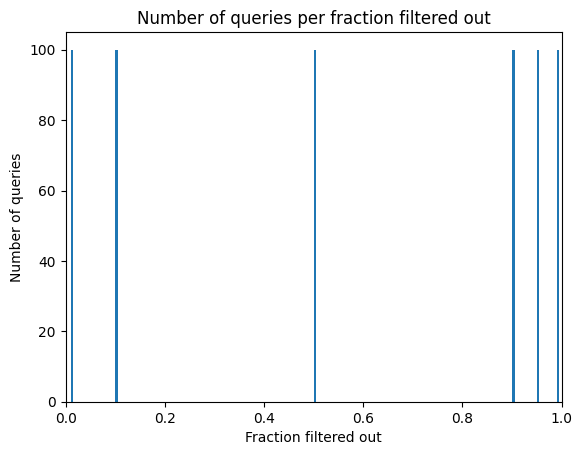

In [53]:
# Plot query distribution
x, y = optimizer.get_query_distribution()
plt.bar(x, y, width=optimizer.get_bucket_interval_width(), align="edge")
plt.title("Number of queries per fraction filtered out")
plt.xlabel("Fraction filtered out")
plt.ylabel("Number of queries")
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

### Step 2: Optimize filterFirstExploration

This parameter controls how much exploration to do when using the filter-first strategy.

In [54]:
print("Determining suggestion for filterFirstExploration")
filter_first_exploration, benchmarks = optimizer.suggest_filter_first_exploration()
print(f"  filterFirstExploration: {round(filter_first_exploration, 3)}")

Determining suggestion for filterFirstExploration
  Benchmarking: 100.0%
  Benchmarking: 100.0%0%
  Computing recall: 100.0%
  Computing recall: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%0%
  Computing recall: 100.0%
  Testing 0.5
  Computing recall: 100.0%
  Testing 0.5
  Benchmarking: 100.0%
  Benchmarking: 100.0%0%
  Computing recall: 100.0%
  Testing 0.25
  Computing recall: 100.0%
  Testing 0.25
  Benchmarking: 100.0%
  Benchmarking: 100.0%0%
  Computing recall: 100.0%
  Testing 0.125
  Computing recall: 100.0%
  Testing 0.125
  Benchmarking: 100.0%
  Benchmarking: 100.0%0%
  Computing recall: 100.0%
  Testing 0.0625
  Computing recall: 100.0%
  Testing 0.0625
  Benchmarking: 100.0%
  Benchmarking: 100.0%0%
  Computing recall: 100.0%
  Testing 0.09375
  Computing recall: 100.0%
  Testing 0.09375
  Benchmarking: 100.0%
  Benchmarking: 100.0%0%
  Computing recall: 100.0%
  Testing 0.109375
  Computing recall: 100.0%
  Testing 0.109375
  Benchmarking: 100.0%
  Benchmarking:

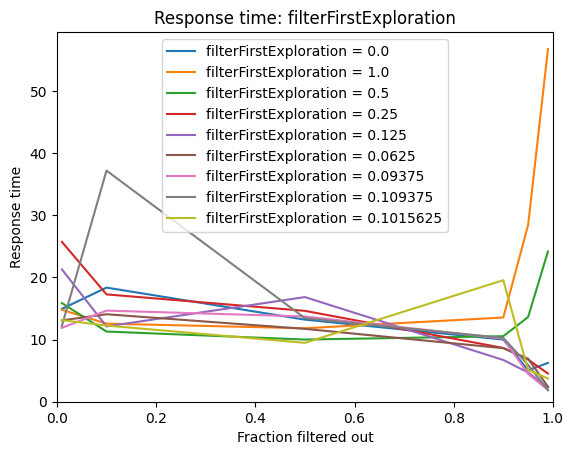

In [55]:
# Plot response time for different filterFirstExploration values
for ffe, benchmark, _ in benchmarks:
    plt.plot(
        optimizer.buckets_to_filtered_out(benchmark.x),
        benchmark.y,
        label=f"filterFirstExploration = {ffe}",
    )

plt.title("Response time: filterFirstExploration")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

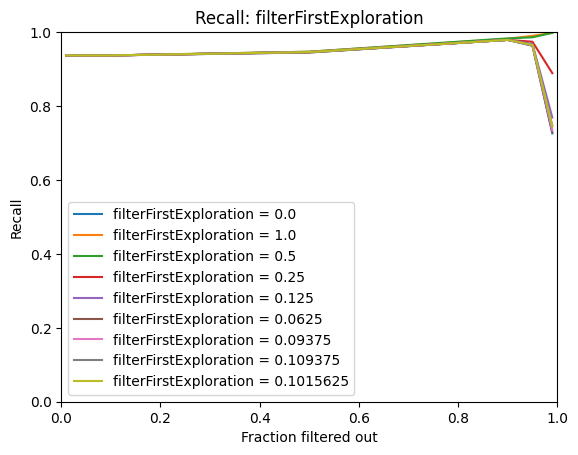

In [56]:
# Plot recall for different filterFirstExploration values
for ffe, _, recall in benchmarks:
    plt.plot(
        optimizer.buckets_to_filtered_out(recall.x),
        recall.y,
        label=f"filterFirstExploration = {ffe}",
    )

plt.title("Recall: filterFirstExploration")
plt.xlabel("Fraction filtered out")
plt.ylabel("Recall")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0, ymax=1)
plt.show()

### Step 3: Optimize filterFirstThreshold

This parameter determines when to use the filter-first strategy based on the fraction of documents filtered out.

In [58]:
print("Determining suggestion for filterFirstThreshold")
hnsw_parameters = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": 0.00,
    "ranking.matching.filterFirstThreshold": 0.00,
}
benchmark_hnsw = optimizer.benchmark(**hnsw_parameters)

filter_first_parameters = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": 0.00,
    "ranking.matching.filterFirstThreshold": 1.00,
    "ranking.matching.filterFirstExploration": filter_first_exploration,
}
benchmark_filter_first = optimizer.benchmark(**filter_first_parameters)

Determining suggestion for filterFirstThreshold
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%


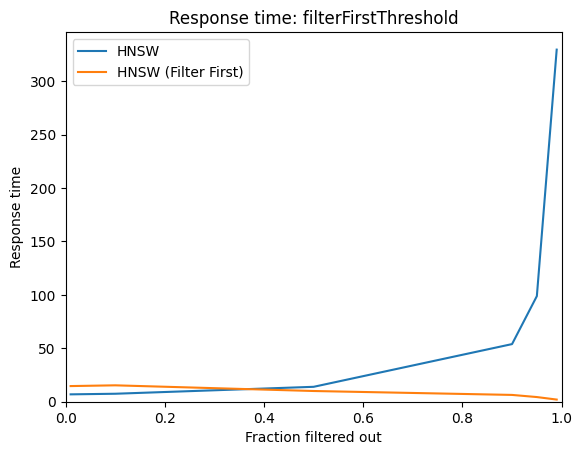

In [59]:
# Plot response time comparison
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_hnsw.x), benchmark_hnsw.y, label="HNSW"
)
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_filter_first.x),
    benchmark_filter_first.y,
    label="HNSW (Filter First)",
)

plt.title("Response time: filterFirstThreshold")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

In [60]:
filter_first_threshold = optimizer.suggest_filter_first_threshold(
    benchmark_hnsw, benchmark_filter_first
)
print(f"  filterFirstThreshold: {round(filter_first_threshold, 3)}")

  filterFirstThreshold: 0.63


### Step 4: Optimize approximateThreshold

This parameter determines when to use exact search vs approximate search.

In [61]:
print("Determining suggestion for approximateThreshold")
exact_parameters = {"timeout": "20s", "ranking.matching.approximateThreshold": 1.00}
benchmark_exact = optimizer.benchmark(**exact_parameters)

filter_first_parameters2 = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": 0.00,
    "ranking.matching.filterFirstThreshold": filter_first_threshold,
    "ranking.matching.filterFirstExploration": filter_first_exploration,
}
benchmark_filter_first2 = optimizer.benchmark(**filter_first_parameters2)

Determining suggestion for approximateThreshold
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%


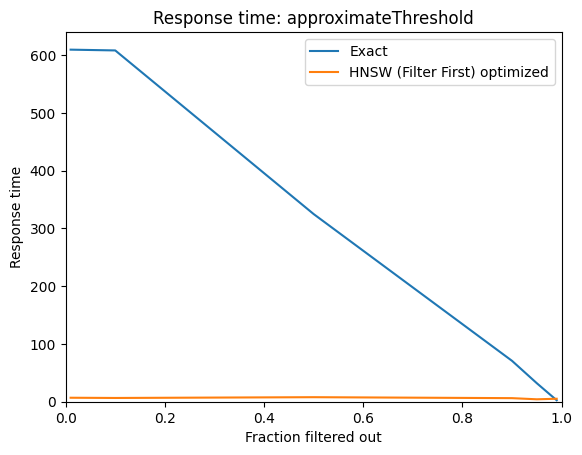

In [62]:
# Plot response time comparison
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_exact.x),
    benchmark_exact.y,
    label="Exact",
)
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_filter_first2.x),
    benchmark_filter_first2.y,
    label="HNSW (Filter First) optimized",
)

plt.title("Response time: approximateThreshold")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

In [63]:
approximate_threshold = optimizer.suggest_approximate_threshold(
    benchmark_exact, benchmark_filter_first2
)
print(f"  approximateThreshold: {round(approximate_threshold, 3)}")

  approximateThreshold: 0.015


### Step 5: Optimize postFilterThreshold

This parameter determines when to use post-filtering vs other strategies.

In [64]:
print("Determining suggestion for postFilterThreshold")
post_filtering_parameters = {
    "timeout": "20s",
    "ranking.matching.postFilterThreshold": 0.00,
    "ranking.matching.approximateThreshold": 0.00,
}
benchmark_post_filtering = optimizer.benchmark(**post_filtering_parameters)

filter_first_parameters3 = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": approximate_threshold,
    "ranking.matching.filterFirstThreshold": filter_first_threshold,
    "ranking.matching.filterFirstExploration": filter_first_exploration,
}
benchmark_filter_first3 = optimizer.benchmark(**filter_first_parameters3)

Determining suggestion for postFilterThreshold
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%


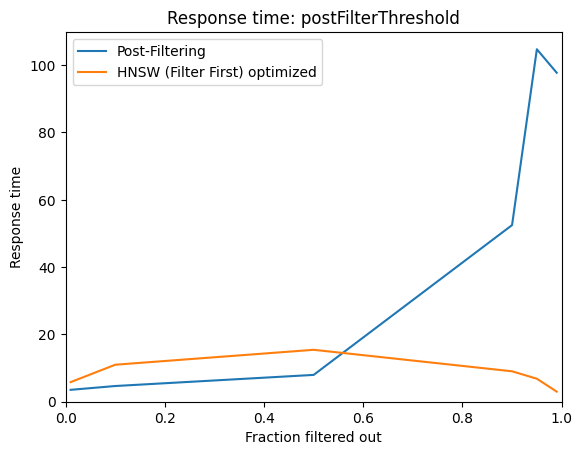

In [65]:
# Plot response time comparison
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_post_filtering.x),
    benchmark_post_filtering.y,
    label="Post-Filtering",
)
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_filter_first3.x),
    benchmark_filter_first3.y,
    label="HNSW (Filter First) optimized",
)

plt.title("Response time: postFilterThreshold")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

In [66]:
recall_post_filtering = optimizer.compute_average_recalls(**post_filtering_parameters)
recall_filter_first3 = optimizer.compute_average_recalls(**filter_first_parameters3)

  Computing recall: 100.0%
  Computing recall: 100.0%
  Computing recall: 100.0%
  Computing recall: 100.0%


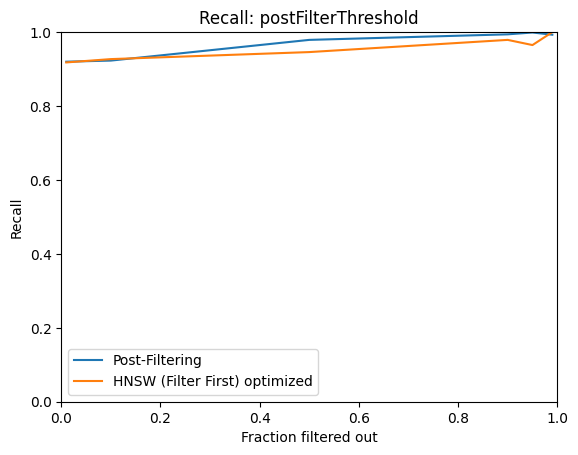

In [67]:
# Plot recall comparison
plt.plot(
    optimizer.buckets_to_filtered_out(recall_post_filtering.x),
    recall_post_filtering.y,
    label="Post-Filtering",
)
plt.plot(
    optimizer.buckets_to_filtered_out(recall_filter_first3.x),
    recall_filter_first3.y,
    label="HNSW (Filter First) optimized",
)

plt.title("Recall: postFilterThreshold")
plt.xlabel("Fraction filtered out")
plt.ylabel("Recall")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0, ymax=1)
plt.show()

In [68]:
post_filter_threshold = optimizer.suggest_post_filter_threshold(
    benchmark_post_filtering,
    recall_post_filtering,
    benchmark_filter_first3,
    recall_filter_first3,
)
print(f"  postFilterThreshold: {round(post_filter_threshold, 3)}")

  postFilterThreshold: 0.44


### Step 6: Compare Current vs Suggested Settings

Finally, let's compare the performance of the current settings with the optimized suggested settings.

In [69]:
print("Comparing current to suggested settings")

suggested_parameters = {
    "timeout": "20s",
    "ranking.matching.approximateThreshold": approximate_threshold,
    "ranking.matching.filterFirstThreshold": filter_first_threshold,
    "ranking.matching.filterFirstExploration": filter_first_exploration,
    "ranking.matching.postFilterThreshold": post_filter_threshold,
}

benchmark_current = optimizer.benchmark()
benchmark_suggested = optimizer.benchmark(**suggested_parameters)

Comparing current to suggested settings
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%
  Benchmarking: 100.0%


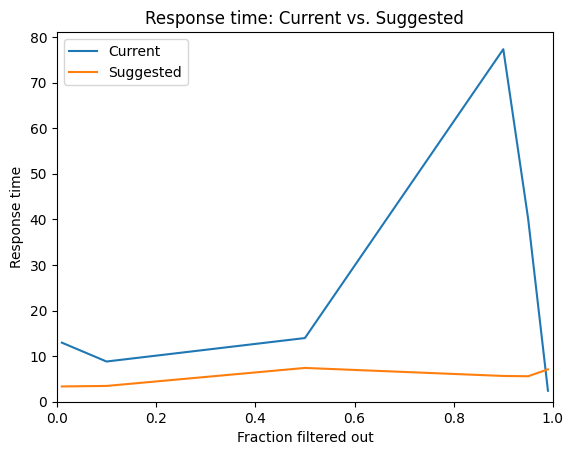

In [70]:
# Plot response time comparison
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_current.x),
    benchmark_current.y,
    label="Current",
)
plt.plot(
    optimizer.buckets_to_filtered_out(benchmark_suggested.x),
    benchmark_suggested.y,
    label="Suggested",
)

plt.title("Response time: Current vs. Suggested")
plt.xlabel("Fraction filtered out")
plt.ylabel("Response time")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0)
plt.show()

In [71]:
recall_current = optimizer.compute_average_recalls()
recall_optimized = optimizer.compute_average_recalls(**suggested_parameters)

  Computing recall: 100.0%
  Computing recall: 100.0%
  Computing recall: 100.0%
  Computing recall: 100.0%


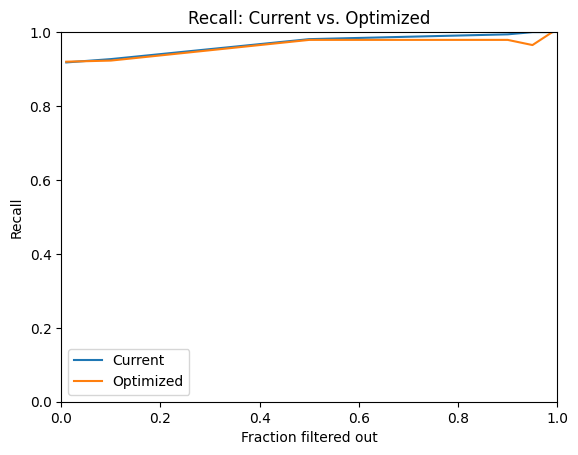

In [72]:
# Plot recall comparison
plt.plot(
    optimizer.buckets_to_filtered_out(recall_current.x),
    recall_current.y,
    label="Current",
)
plt.plot(
    optimizer.buckets_to_filtered_out(recall_optimized.x),
    recall_optimized.y,
    label="Optimized",
)

plt.title("Recall: Current vs. Optimized")
plt.xlabel("Fraction filtered out")
plt.ylabel("Recall")
plt.legend()
axs = plt.gca()
axs.set_xlim(xmin=0, xmax=1)
axs.set_ylim(ymin=0, ymax=1)
plt.show()

## Summary

The optimization process has determined the following suggested parameters:

- **filterFirstExploration**: Controls exploration when using filter-first strategy
- **filterFirstThreshold**: Determines when to use filter-first based on fraction filtered
- **approximateThreshold**: Determines when to use exact vs approximate search
- **postFilterThreshold**: Determines when to use post-filtering strategy

These optimized parameters should provide better performance while maintaining recall quality.